# Imports

## Libraries

In [15]:
import os
import re
import string
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import pandas as pd
import numpy as np
from collections import defaultdict


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")

## Data

### Raw

In [2]:
data_folder_path = '/text-mining/data/02_text_representation/Corpus-representacion'

In [3]:
def save_files_to_dict(folder_path):
    files_dict = {}
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    files_dict[file_path] = f.read()
            except Exception as e:
                print(f"Could not read file {file_path}: {e}")
    return files_dict

In [4]:
data_dict = save_files_to_dict(data_folder_path)
data = list(data_dict.values())
len(data)

866

### Labels

In [5]:
categories = [path.split('/')[-2] for path in data_dict.keys()]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(categories)
unique_categories = list(set(categories))
print(unique_categories)

['comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'talk.politics.guns', 'rec.sport.hockey', 'rec.autos', 'sci.electronics', 'talk.politics.mideast']


### Representations

In [6]:
tf_representations = np.load("../02_text_representation/02_text_representations_tf.npy")
tfidf_representations = np.load("../02_text_representation/02_text_representations_tfidf.npy")
word2vec_avg_representations = np.load("../02_text_representation/02_text_representations_word2vec_avg.npy")
word2vec_sum_representations = np.load("../02_text_representation/02_text_representations_word2vec_sum.npy")

# Analysis

In [7]:
def analyze_document_statistics(data, categories, unique_categories):
    """
    Analyze document statistics by category and create visualizations.

    Args:
        data: List of document texts
        categories: List of category labels for each document
        unique_categories: List of unique category names
    """
    # Calculate word counts for each category
    category_stats = {}

    for i, category in enumerate(unique_categories):
        # Get indices for this category
        category_indices = [j for j, cat in enumerate(categories) if cat == category]

        # Get documents for this category
        category_docs = [data[j] for j in category_indices]

        # Calculate word counts
        word_counts = [len(doc.split()) for doc in category_docs]

        # Store statistics
        category_stats[category] = {
            'doc_count': len(category_docs),
            'word_count_mean': np.mean(word_counts) if word_counts else 0, # Handle empty categories
            'word_count_std': np.std(word_counts) if word_counts else 0   # Handle empty categories
        }

    # Print statistics information
    print("Document Statistics by Category:")
    for category, stats in category_stats.items():
        print(f"\n{category}:")
        print(f"  Number of documents: {stats['doc_count']}")
        print(f"  Mean word count: {stats['word_count_mean']:.2f} words")
        print(f"  Std word count: {stats['word_count_std']:.2f} words")

    # Create dataframe for plotting
    word_count_df = pd.DataFrame({
        'Category': list(category_stats.keys()),
        'Mean Word Count': [stats['word_count_mean'] for stats in category_stats.values()],
        'Std Word Count': [stats['word_count_std'] for stats in category_stats.values()]
    })

    # --- Plot for Number of Documents ---
    plt.figure(figsize=(10, 8))
    doc_counts = [stats['doc_count'] for stats in category_stats.values()]
    categories_for_plot = list(category_stats.keys())
    ax_doc_count = sns.barplot(x=categories_for_plot, y=doc_counts)

    # Add values on top of bars
    for i, p in enumerate(ax_doc_count.patches):
        ax_doc_count.annotate(f'{p.get_height():.0f}',
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='bottom', fontsize=10)

    plt.title('Number of Documents by Category')
    plt.ylabel('Number of Documents')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # --- End Plot for Number of Documents ---

    # Plot word count statistics
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x='Category', y='Mean Word Count', data=word_count_df)

    # Add values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.errorbar(
        x=np.arange(len(word_count_df)),
        y=word_count_df['Mean Word Count'],
        yerr=word_count_df['Std Word Count'],
        fmt='none', capsize=5, color='black'
    )
    plt.title('Mean Word Count by Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return category_stats

Document Statistics by Category:

comp.sys.mac.hardware:
  Number of documents: 146
  Mean word count: 184.38 words
  Std word count: 108.42 words

comp.sys.ibm.pc.hardware:
  Number of documents: 124
  Mean word count: 247.70 words
  Std word count: 373.05 words

talk.politics.guns:
  Number of documents: 141
  Mean word count: 414.33 words
  Std word count: 473.05 words

rec.sport.hockey:
  Number of documents: 50
  Mean word count: 273.88 words
  Std word count: 265.68 words

rec.autos:
  Number of documents: 122
  Mean word count: 216.21 words
  Std word count: 170.52 words

sci.electronics:
  Number of documents: 211
  Mean word count: 265.78 words
  Std word count: 807.43 words

talk.politics.mideast:
  Number of documents: 72
  Mean word count: 726.88 words
  Std word count: 1321.51 words


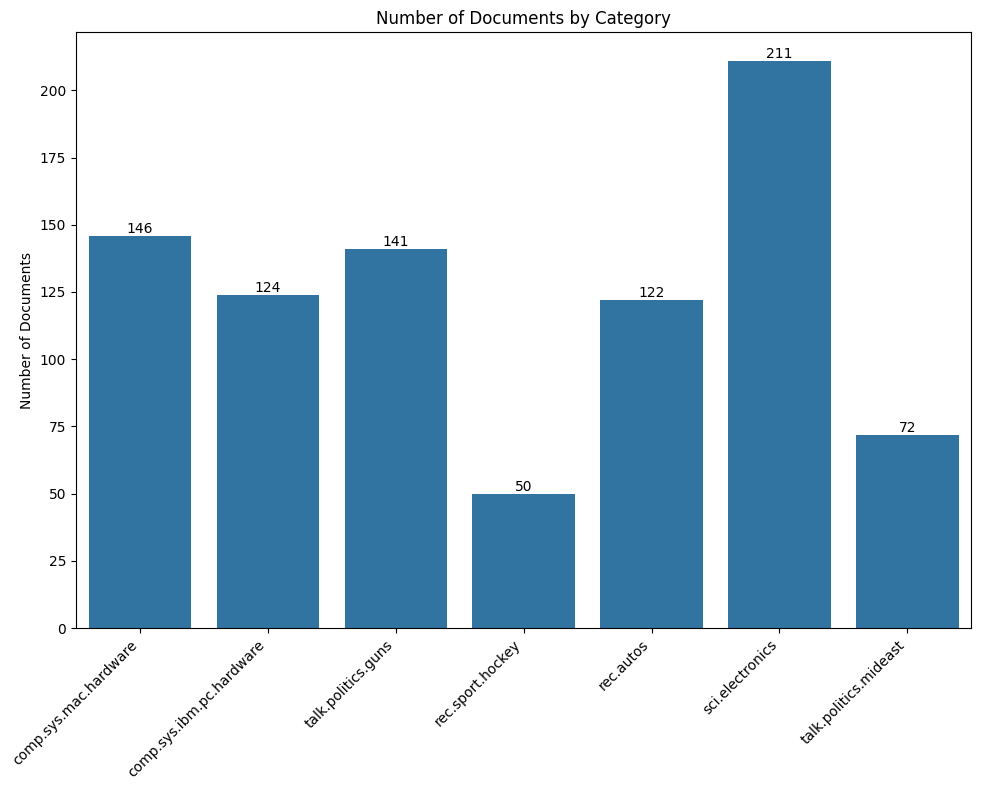

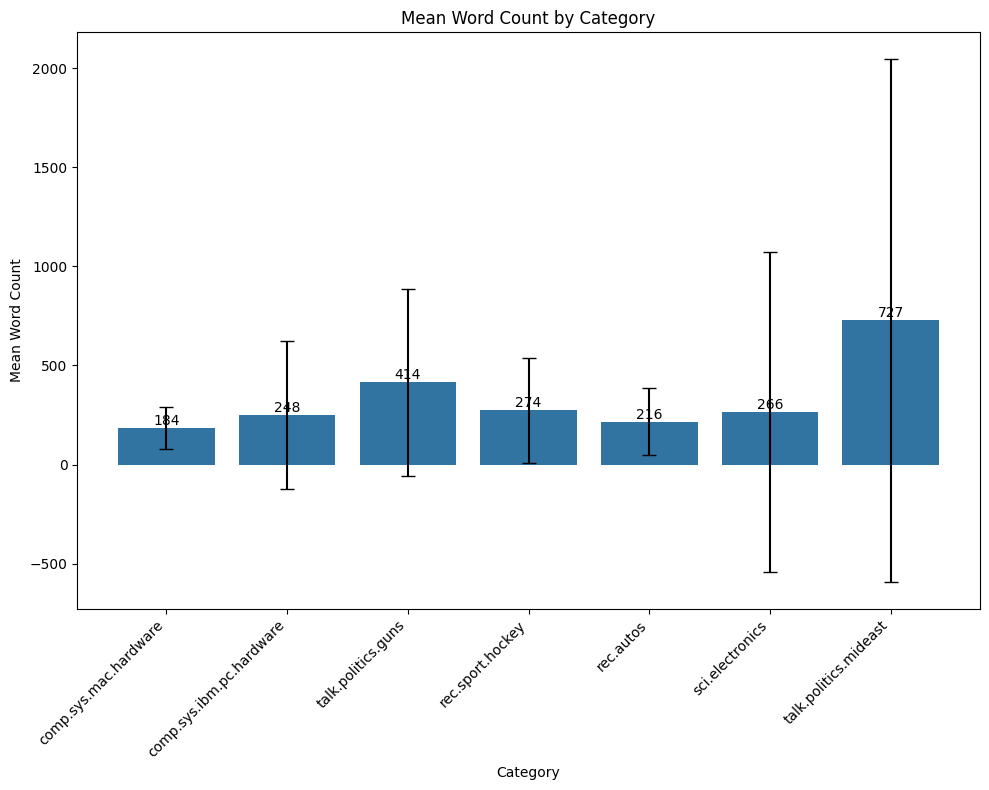

In [8]:
category_stats = analyze_document_statistics(data, categories, unique_categories)

# Clustering

In [20]:
def bcubed_score(true_labels, predicted_clusters):
    """
    Calculate B-cubed precision, recall and F1 score.
    
    Args:
        true_labels: Array of true cluster labels
        predicted_clusters: Array of predicted cluster labels
    
    Returns:
        tuple: (precision, recall, f_score)
    """
    # Create mapping from labels to indices for both true and predicted labels
    true_label_to_indices = defaultdict(list)
    pred_label_to_indices = defaultdict(list)
    
    for i, (true_label, pred_label) in enumerate(zip(true_labels, predicted_clusters)):
        true_label_to_indices[true_label].append(i)
        pred_label_to_indices[pred_label].append(i)
    
    # Calculate precision and recall for each data point
    precision_sum = 0.0
    recall_sum = 0.0
    n = len(true_labels)
    
    for i in range(n):
        true_label = true_labels[i]
        pred_label = predicted_clusters[i]
        
        # Get all items with the same predicted label
        pred_cluster = set(pred_label_to_indices[pred_label])
        # Get all items with the same true label
        true_cluster = set(true_label_to_indices[true_label])
        
        # Intersection of the clusters
        overlap = len(pred_cluster.intersection(true_cluster))
        
        # Calculate precision and recall for this data point
        precision = overlap / len(pred_cluster) if len(pred_cluster) > 0 else 0
        recall = overlap / len(true_cluster) if len(true_cluster) > 0 else 0
        
        precision_sum += precision
        recall_sum += recall
    
    # Calculate average precision and recall
    precision = precision_sum / n
    recall = recall_sum / n
    
    # Calculate F1 score
    f_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f_score

def evaluate_clustering(true_labels, predicted_clusters):
    """
    Evaluate clustering with multiple metrics.
    
    Args:
        true_labels: Array of true cluster labels
        predicted_clusters: Array of predicted cluster labels
        
    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    # Since true_labels could be strings, we need to ensure both are numeric for some metrics
    if isinstance(true_labels[0], str):
        # We'll use LabelEncoder for this example
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        numeric_true_labels = le.fit_transform(true_labels)
    else:
        numeric_true_labels = true_labels
    
    # Reassign clusters to match true labels (from your existing function logic)
    correspondences = {}
    unique_clusters = np.unique(predicted_clusters)
    for cluster in unique_clusters:
        cluster_indices = np.where(predicted_clusters == cluster)
        true_labels_for_cluster = numeric_true_labels[cluster_indices]
        if len(true_labels_for_cluster) > 0:
            most_common_label = np.bincount(true_labels_for_cluster).argmax()
            correspondences[cluster] = most_common_label
    
    # Reassign predicted clusters
    reassigned_clusters = np.array([correspondences[cluster] for cluster in predicted_clusters])
    
    # Calculate metrics
    # 1. Adjusted Rand Index
    ari = adjusted_rand_score(numeric_true_labels, predicted_clusters)
    
    # 2. B-cubed metrics
    bcubed_prec, bcubed_rec, bcubed_f1 = bcubed_score(numeric_true_labels, predicted_clusters)
    
    # 3. Homogeneity, completeness and V-measure
    homogeneity = homogeneity_score(numeric_true_labels, predicted_clusters)
    completeness = completeness_score(numeric_true_labels, predicted_clusters)
    v_measure = v_measure_score(numeric_true_labels, predicted_clusters)
    
    # 4. Accuracy after reassignment (similar to what you already calculated)
    accuracy = np.mean(numeric_true_labels == reassigned_clusters)
    
    return {
        'accuracy': accuracy,
        'adjusted_rand_index': ari,
        'bcubed_precision': bcubed_prec,
        'bcubed_recall': bcubed_rec,
        'bcubed_f1': bcubed_f1,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'predicted_clusters': predicted_clusters,
        'reassigned_clusters': reassigned_clusters
    }

def run_all_clustering_algorithms(representations_dict, n_clusters, true_labels):
    """
    Run all clustering algorithms on all representations and collect results.
    
    Args:
        representations_dict: Dictionary of representations
        n_clusters: Number of clusters
        true_labels: True class labels
    
    Returns:
        DataFrame: Results of all clustering experiments
    """
    results = []
    
    for rep_name, rep_data in representations_dict.items():
        # K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_clusters = kmeans.fit_predict(rep_data)
        kmeans_results = evaluate_clustering(true_labels, kmeans_clusters)
        results.append({
            'representation': rep_name,
            'algorithm': 'K-means',
            **kmeans_results
        })
        
        # Agglomerative Clustering
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        agg_clusters = agglomerative.fit_predict(rep_data)
        agg_results = evaluate_clustering(true_labels, agg_clusters)
        results.append({
            'representation': rep_name,
            'algorithm': 'Agglomerative',
            **agg_results
        })
        
        # Spectral Clustering
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
        spectral_clusters = spectral.fit_predict(rep_data)
        spectral_results = evaluate_clustering(true_labels, spectral_clusters)
        results.append({
            'representation': rep_name,
            'algorithm': 'Spectral Clustering',
            **spectral_results
        })
        
        # Bisecting K-means
        bisecting_kmeans = BisectingKMeans(n_clusters=n_clusters, random_state=42)
        bisecting_clusters = bisecting_kmeans.fit_predict(rep_data)
        bisecting_results = evaluate_clustering(true_labels, bisecting_clusters)
        results.append({
            'representation': rep_name,
            'algorithm': 'Bisecting K-means',
            **bisecting_results
        })
    
    # Convert to DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
n_clusters = 7

representations_dict = {
    'tf': tf_representations,
    'tfidf': tfidf_representations,
    'word2vec_avg': word2vec_avg_representations,
    'word2vec_sum': word2vec_sum_representations
}

# Run all clustering algorithms on all representations
results_df = run_all_clustering_algorithms(representations_dict, n_clusters, true_labels)

# Evaluation

In [22]:
def plot_top_confusion_matrices(results_df, true_labels, metric='bcubed_f1', top_n=3):
    """
    Plot confusion matrices for the top performing clustering results.
    
    Args:
        results_df: DataFrame with clustering results
        true_labels: True class labels
        metric: Metric to sort by (default: bcubed_f1)
        top_n: Number of top performers to plot
    """
    # Sort results by the chosen metric
    top_results = results_df.sort_values(by=metric, ascending=False).head(top_n)
    
    # Create a figure with subplots for top N results
    fig, axes = plt.subplots(1, top_n, figsize=(20, 6))
    
    for i, (_, row) in enumerate(top_results.iterrows()):
        # Get predicted clusters
        predicted_clusters = row['predicted_clusters']
        reassigned_clusters = row['reassigned_clusters']
        
        # Create confusion matrix
        cm = confusion_matrix(true_labels, reassigned_clusters)
        
        # Plot on the corresponding subplot
        ax = axes[i] if top_n > 1 else axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"Algorithm: {row['algorithm']}\nRepresentation: {row['representation']}\n{metric}: {row[metric]:.3f}")
        ax.set_xlabel('Predicted Clusters')
        ax.set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.show()

def plot_best_per_algorithm(results_df, true_labels, metric='bcubed_f1'):
    """
    Plot the best confusion matrix for each clustering algorithm.
    
    Args:
        results_df: DataFrame with clustering results
        true_labels: True class labels
        metric: Metric to sort by (default: bcubed_f1)
    """
    # Get unique algorithms
    algorithms = results_df['algorithm'].unique()
    
    # Create a figure with subplots for each algorithm
    fig, axes = plt.subplots(1, len(algorithms), figsize=(20, 6))
    
    for i, algorithm in enumerate(algorithms):
        # Filter results for the current algorithm
        algo_results = results_df[results_df['algorithm'] == algorithm]
        
        # Get the best result for the current algorithm
        best_result = algo_results.sort_values(by=metric, ascending=False).head(1)
        
        for _, row in best_result.iterrows():
            # Get predicted clusters
            predicted_clusters = row['predicted_clusters']
            reassigned_clusters = row['reassigned_clusters']
            
            # Create confusion matrix
            cm = confusion_matrix(true_labels, reassigned_clusters)
            
            # Plot on the corresponding subplot
            ax = axes[i] if len(algorithms) > 1 else axes
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f"Algorithm: {row['algorithm']}\nRepresentation: {row['representation']}\n{metric}: {row[metric]:.3f}")
            ax.set_xlabel('Predicted Clusters')
            ax.set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.show()



Clustering Results Summary (sorted by B-cubed F1 score):


,representation,algorithm,accuracy,adjusted_rand_index,bcubed_precision,bcubed_recall,bcubed_f1,homogeneity,completeness,v_measure
0,word2vec_avg,Spectral Clustering,0.62,0.36,0.52,0.66,0.58,0.49,0.58,0.53
1,tfidf,Agglomerative,0.53,0.25,0.42,0.74,0.53,0.38,0.59,0.46
2,tfidf,Spectral Clustering,0.50,0.30,0.43,0.67,0.53,0.43,0.58,0.49
3,word2vec_avg,Agglomerative,0.51,0.28,0.41,0.56,0.47,0.40,0.48,0.43
4,word2vec_avg,K-means,0.51,0.28,0.39,0.53,0.45,0.36,0.43,0.39
5,word2vec_avg,Bisecting K-means,0.48,0.25,0.39,0.44,0.41,0.37,0.39,0.38
6,tfidf,Bisecting K-means,0.52,0.24,0.39,0.41,0.40,0.36,0.36,0.36
7,tfidf,K-means,0.50,0.21,0.37,0.39,0.38,0.32,0.33,0.33
8,tf,Spectral Clustering,0.34,0.03,0.25,0.79,0.38,0.12,0.37,0.18
9,tf,Agglomerative,0.26,0.01,0.18,0.94,0.31,0.03,0.31,0.06



Top 3 results based on B-cubed F1 score:


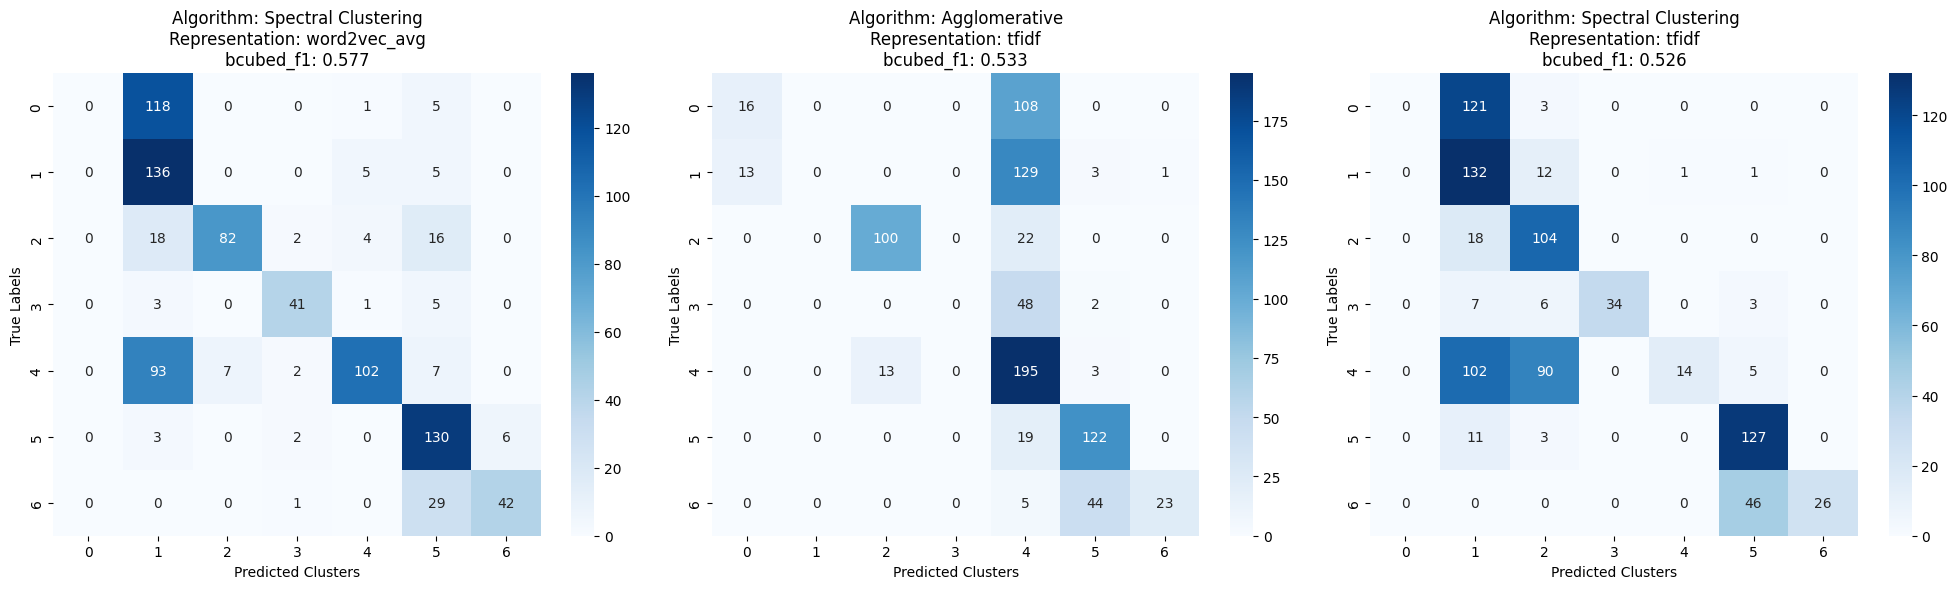


Best result for each algorithm based on B-cubed F1 score:


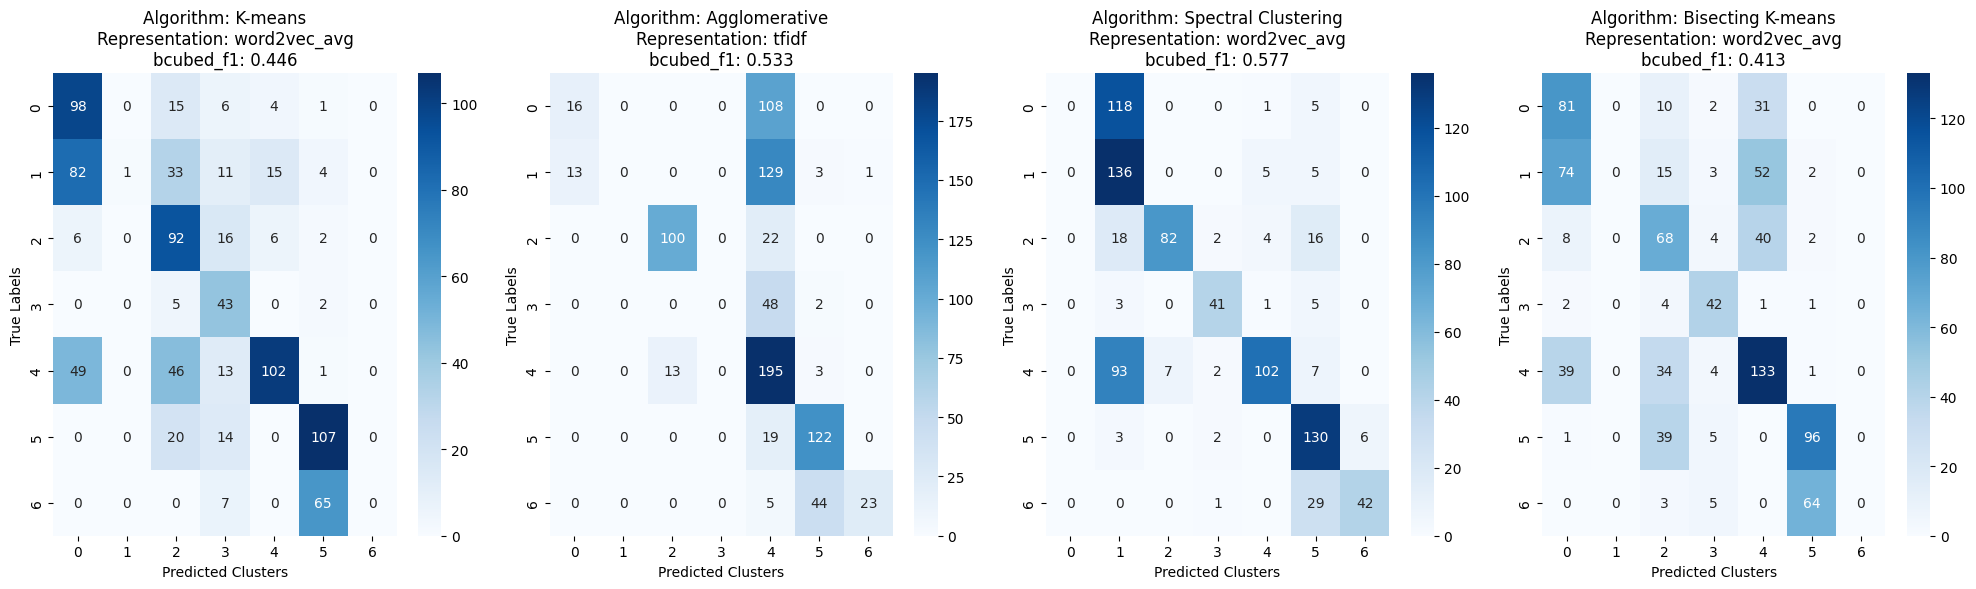

In [25]:
# Display the results table sorted by bcubed_f1 in descending order
print("Clustering Results Summary (sorted by B-cubed F1 score):")
display(results_df.sort_values(by='bcubed_f1', ascending=False)[['representation', 'algorithm', 'accuracy', 'adjusted_rand_index', 
                    'bcubed_precision', 'bcubed_recall', 'bcubed_f1',
                    'homogeneity', 'completeness', 'v_measure']].reset_index(drop=True).round(2))

# Visualize the top 3 results based on B-cubed F1 score
print("\nTop 3 results based on B-cubed F1 score:")
plot_top_confusion_matrices(results_df, true_labels, metric='bcubed_f1', top_n=3)

# Visualize the best result for each algorithm
print("\nBest result for each algorithm based on B-cubed F1 score:")
plot_best_per_algorithm(results_df, true_labels, metric='bcubed_f1')